In [1]:
import sys
import json
import pandas as pd
import numpy as np
from src.utils_methods import encode, get_var_metadata, post_process, transform_df_to_json, generate_plots, check_constraints

RUNNING ON CPU


In [2]:
import json
data_folder = "results/evaluated/"
with open(data_folder + "real/real_structures_evaluated.json") as f:
    real = json.load(f)
with open("results/real/real_structures.json") as f:
    real_not_eval = json.load(f)

irrelevant = set(real_not_eval[0].keys())
col_set = set(real[0].keys())
objectives_to_extract = list(col_set - irrelevant)
print(objectives_to_extract)

with open(data_folder + "GA/P[None]_seed_0_evaluated.json") as f:
    ga_no_plaus = json.load(f)

with open(data_folder + "dgmm_ga/dgmm(real_ga_no_plaus)_10000_evaluated.json") as f:
    dgmm_synth = json.load(f)

# concat_r_ga = real + ga_no_plaus
    
DATA_ARRAY = [real, ga_no_plaus, dgmm_synth]
DATA_NAMES = ["Real", "\\nsga", "\makecell{\mdgmm//(Real,\\nsga)}"]

['Cost', 'plausibility (SVM)', 'wave', 'plausibility (FAMD GMM)', 'compression', 'plausibility (FAMD One Class SVM) gamma=scale nu=0.5', 'torque', 'plausibility (One Class SVM) gamma=scale nu=0.5', 'combined', 'tipover', 'plausibility (FAMD Mahalanobis)']


In [3]:
brace_dict = {    
    "NONE": 0,
    "H": 1,
    "Z": 2,
    "IZ": 3,
    "ZH": 4,
    "IZH": 5,
    "K": 6,
    "X": 7,
    "XH": 8,
    "nan": 9,
}

brace_dict_inv = dict(zip(brace_dict.values(), brace_dict.keys()))

N_BRACES = len(brace_dict)

In [4]:
max_layers = max(d.get('n_layers', 0) for sublist in DATA_ARRAY for d in sublist)
transformed_columns = ["legs", "total_height", "radius_bottom", "radius_top", "n_layers"]
brace_cols = ["brace" + str(i) for i in range(max_layers-1)] 
transformed_columns += brace_cols
transformed_columns += ["layer_height" + str(i) for i in range(max_layers-2)]

encoded = []
Y = []



y_columns_to_extract = ['Cost', 'tipover', 'combined', 'compression', 'wave', 'torque']

for dataset, name in zip(DATA_ARRAY, DATA_NAMES):

    encoding = [encode(d, max_layers, brace_dict, N_BRACES, one_hot=False, native=True, normalize_layer_heights=True) for d in dataset]
    extracted_data = [{col: entry[col] for col in y_columns_to_extract} for entry in dataset]

    # Create a DataFrame
    y = pd.DataFrame(extracted_data)
    encoded.append(encoding)
    Y.append(y)

    
X = []
for count, encoding in enumerate(encoded):
    df_ = pd.DataFrame(encoding, columns=transformed_columns)
    # df_["label"] = [DATA_NAMES[count]]*len(df_)
    X.append(df_.copy())


In [5]:
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

In [6]:
columns_one_hot = brace_cols
columns_standard = list(set(transformed_columns) - set(brace_cols))
# augmented = pd.concatenate(X) 
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.sparse import hstack
from sklearn.compose import ColumnTransformer

from sklearn.base import BaseEstimator, TransformerMixin


class CustomTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns_one_hot, columns_standard, unique_categories, columns):
        self.columns_one_hot = columns_one_hot
        self.columns_standard = columns_standard
        self.columns = columns
        self.unique_categories = unique_categories
        self.encoders = []

    def fit(self, X, y=None):
        for i in range(X.shape[-1]):
            name = self.columns[i]
            if name in columns_standard:
                encoder = StandardScaler()
                encoder.fit(X.iloc[:,i:i+1])
            self.encoders.append(encoder)
        return self

    def transform(self, X, y=None):
        transformed = []
        for i, encoder in enumerate(self.encoders):
            name = self.columns[i]
            if name in columns_standard:
                tr = encoder.transform(X.iloc[:, i:i+1])
                transformed.append(tr)
            else:
                mapping = self.unique_categories[name]
                tr = X[name].map(mapping).values.reshape(-1,1)
                transformed.append(tr)
                
        return np.concatenate(transformed, axis=-1)

def get_unique_all(X, columns_one_hot):

    all_categories = {}
    for column in columns_one_hot:
        unique_categories = set()
        for df in X:
            unique_categories.update(df[column].unique())
        all_categories[column] = mapping = {val: idx for idx, val in enumerate(list(unique_categories))} 
    return all_categories

unique_categories = get_unique_all(X, columns_one_hot)
print(unique_categories)
enc_columntransfo = CustomTransformer(columns_one_hot, columns_standard, unique_categories, X[0].columns)
cty = MinMaxScaler()

X_real_transformed = pd.DataFrame(enc_columntransfo.fit_transform(X[0]))
y_real_transformed = cty.fit_transform(Y[0])
# y_real_transformed = np.array(Y[0])

synthetic_Xs = []
synthetic_ys = []

for i in range(1, len(X)): 
    synthetic_Xs.append(enc_columntransfo.transform(X[i]))
    synthetic_ys.append(cty.transform(Y[i]))
    # synthetic_ys.append(np.array(Y[i]))

# y_inv = cty.inverse_transform(y_real_transformed)



{'brace0': {'X': 0, 'XH': 1, 'NONE': 2, 'K': 3, 'Z': 4, 'IZ': 5}, 'brace1': {'X': 0, 'nan': 1, 'K': 2, 'H': 3, 'NONE': 4, 'XH': 5, 'Z': 6, 'IZ': 7}, 'brace2': {'X': 0, 'nan': 1, 'K': 2, 'NONE': 3, 'XH': 4, 'Z': 5, 'IZ': 6}, 'brace3': {'X': 0, 'nan': 1, 'H': 2, 'K': 3, 'NONE': 4, 'XH': 5, 'Z': 6}, 'brace4': {'X': 0, 'nan': 1, 'K': 2, 'NONE': 3, 'XH': 4, 'Z': 5}}


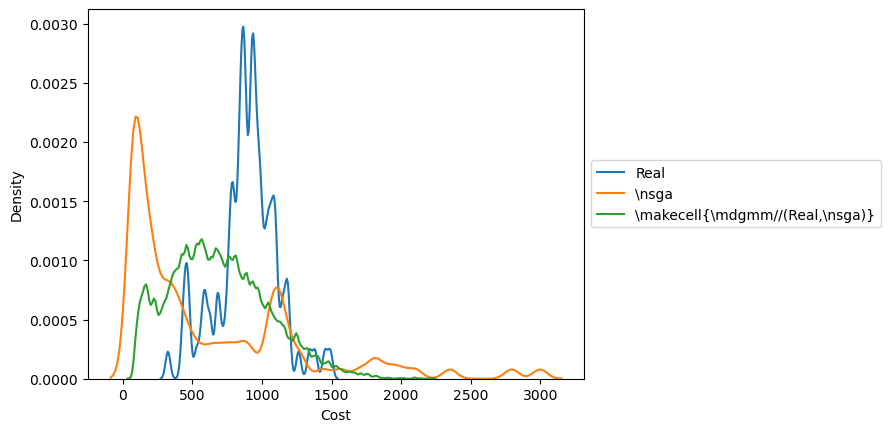

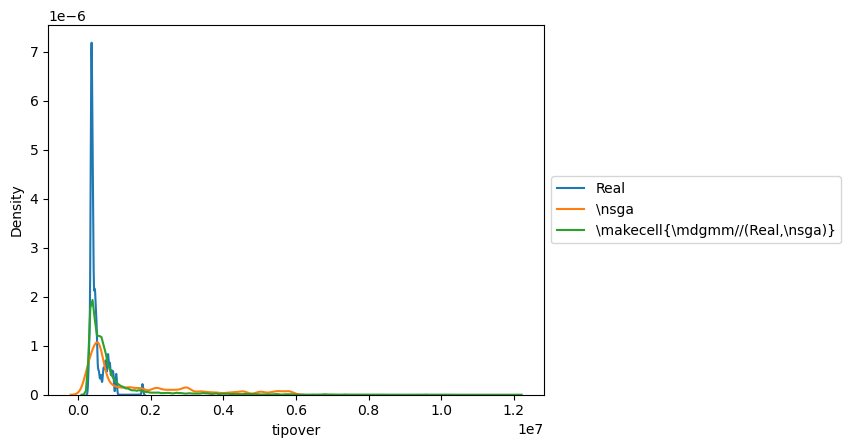

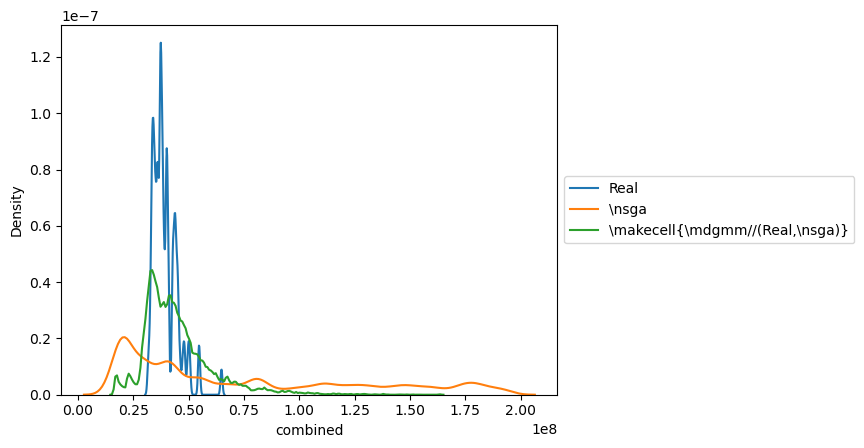

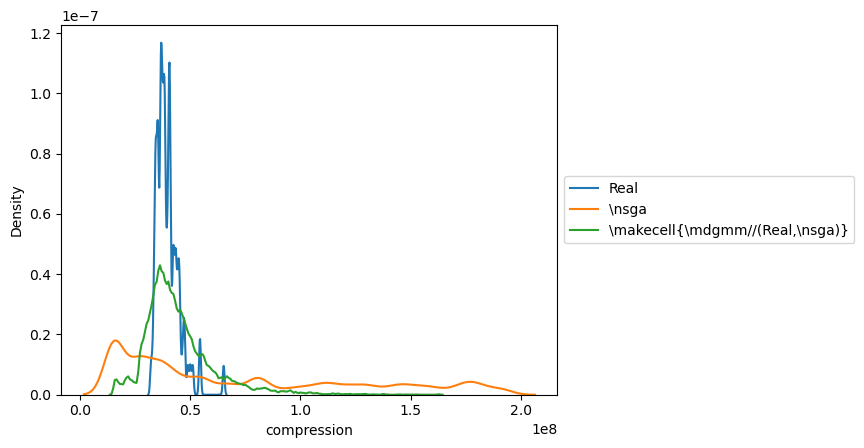

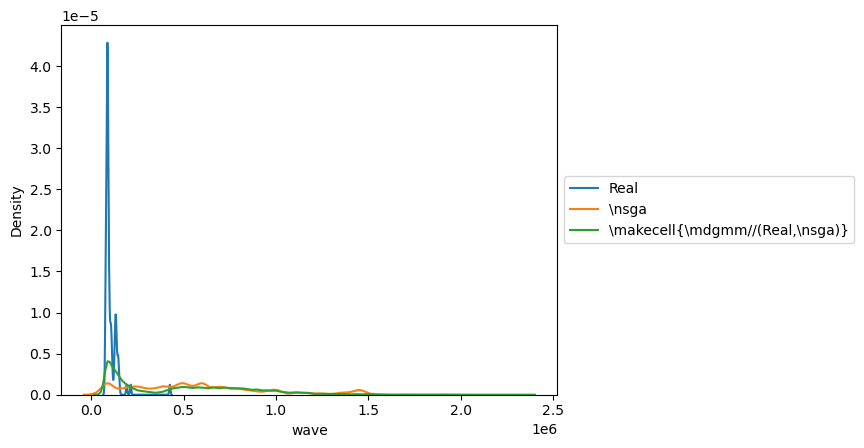

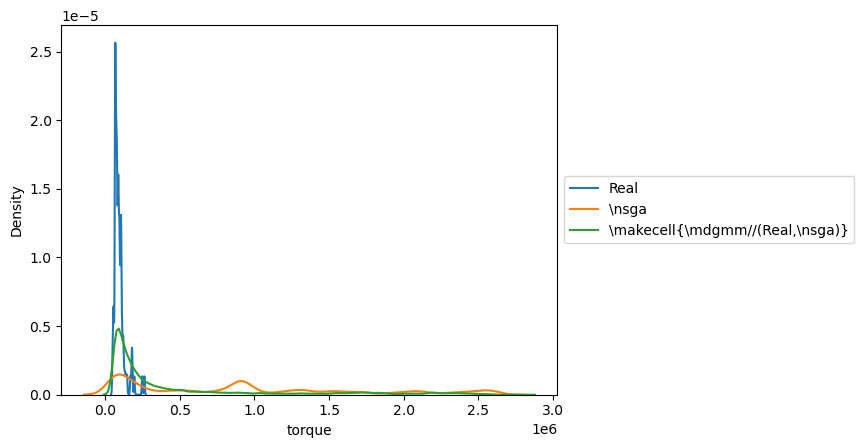

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
bw = 0.2

for col in range(Y[0].shape[-1]):
    for row in range(len(Y)): 
        g = sns.kdeplot(Y[row].iloc[:, col], bw_adjust=bw, label=DATA_NAMES[row])
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
# stds = 3

# for col in range(Y[0].shape[-1]):
#     column_data = [Y[row].iloc[:, col] for row in range(1, len(Y)-1)]
    
#     # Combine data from all rows in the column
#     combined_data = np.concatenate(column_data)
#     std_dev = np.std(combined_data)
#     mean_dev = np.mean(combined_data)
#     # Calculate z-scores
#     min_value = mean_dev - stds* std_dev
#     max_value = mean_dev + stds* std_dev
#     clip_range = (min_value, max_value)  # Adjust this range as needed

#     for row in range(1, len(Y)-1): 
#         g = sns.kdeplot(Y[row].iloc[:, col], bw_adjust=bw, label=DATA_NAMES[row], clip=clip_range)
    
#     plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#     plt.show()

In [8]:
def generate_latex_table(names_all, problem, all_metrics_mean, all_metrics_std):
    all_cols = str(len(names_all)**2 +1)
    latex_table = "\\begin{table}\n"
    latex_table += "\\centering\n"
    latex_table += "\\scalebox{0.70}{\n"
    latex_table += "\\begin{tabular}{|c|*{" + all_cols + "}{c|}}\n"
    latex_table += "\\hline\n"
    
    latex_table += "Train data & \\multicolumn{" + str(len(names_all)) + "}{c|}{Real} & "
    latex_table += "\\multicolumn{" + str(len(names_all)) + "}{c|}{Synthetic} & "
    latex_table += "\\multicolumn{" + str(len(names_all)) + "}{c|}{Augmented} \\\\\n"
    latex_table += "\\cline{2-" + all_cols + "}\n"
    
    latex_table += "Test data & " + " & ".join([name for _ in range(len(names_all)) for name in names_all]) + " \\\\\n"

    latex_table += "\\cline{2-" + all_cols + "}\n"
    
    # for name in names_all:
    #     for _ in range(len(problem["metric_names"])):
    #         latex_table += f"& {name} "
    # latex_table += "\\\\\n"
    # latex_table += "\\cline{2-" + all_cols + "}\n"
    
    for metric_row in range(len(problem["metric_names"])):
        metric_name = problem["metric_names"][metric_row]
        latex_table += f"{metric_name} "
        for metric_col in range(len(names_all)):
            for name_row in range(len(names_all)):
                    # print(all_metrics_mean[metric_row])
                    # print(all_metrics_mean[metric_row][name_row])
                    avg_metric = all_metrics_mean[metric_row][name_row][metric_col]
                    std_metric = all_metrics_std[metric_row][name_row][metric_col]
                    latex_table += f"& {avg_metric:.3f} ({std_metric:.3f})"
        latex_table += " \\\\\n"
        if metric_row < len(problem["metric_names"]) - 1:
            latex_table += "\\cline{2-" + all_cols + "}\n"
        else:
            latex_table += "\\hline\n"
    
    latex_table += "\\end{tabular}\n"
    latex_table += "}\n"
    latex_table += "\\caption{Comparison}\n"
    latex_table += "\\label{tab:eval}\n"
    latex_table += "\\end{table}"
    
    return latex_table

In [9]:
import numpy as np
from sklearn.model_selection import cross_val_score, RepeatedKFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.exceptions import NotFittedError

def compute_metrics(y_test, y_pred, problem, name_tr, name_t):
    return [m(y_test, y_pred) for m in problem["metrics"]]

def train_eval(X_train, y_train, X_test, y_test, problem, name_tr, name_t):
    model = problem["model"](**problem["args"])
    try:
        model.predict(X_test)
        print(name_tr, name_t, "Model is already fitted!")
        exit(1)
    except:
        pass
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    metrics = compute_metrics(y_test, y_pred, problem, name_tr, name_t)
    return metrics, y_pred

def make_problem(X_real, y_real, X_s, y_s, problem, names_all, print_percentages=False):
    if "regression" in problem.keys():
        X_r = np.array(X_real)
        y_r = np.array(y_real[:,problem["regression"]])
        ll = []
        for y in y_s:
            ll.append(np.array(y[:,problem["regression"]]))
    else:
        X_r = np.array(X_real)
        threshold = problem["threshold_metric"](y_real[:,problem["classification"]])
        y_r_binary = (y_real[:,problem["classification"]] > threshold).astype(int)
        y_r = np.array(y_r_binary)
        if print_percentages:
            print('\n'.join(f'{names_all[0]} Class {c}: {count/len(y_r)*100:.2f}%' for c, count in enumerate(np.bincount(y_r))))

        ll = []
        for y, n in zip(y_s, names_all[1:]):
            threshold = problem["threshold_metric"](y[:,problem["classification"]])
            y_binary = (y[:,problem["classification"]] > threshold).astype(int)
            y_binary = np.array(y_binary)
            if print_percentages:
                print('\n'.join(f'{n} Class {c}: {count/len(y_binary)*100:.2f}%' for c, count in enumerate(np.bincount(y_binary))))

            ll.append(y_binary)
    return X_r, y_r, [np.array(x) for x in X_s], ll

def run_experiments(X_real, y_real, synthetic_Xs, synthetic_ys, problems, names_all, output_names, bw=0.5,
                     plot=False, augment=False, num_repeats = 1, num_folds = 2):
    average_problems = []
    std_problems = []
    for problem in problems:
        print("Model", problem["model_name"])    

        X_real_, y_real_, synthetic_Xs_, synthetic_ys_ = make_problem(X_real, y_real, synthetic_Xs, synthetic_ys, problem, names_all)
        # Assuming you have X and y defined

        # Create an MLP regression model

        # Set up repeated cross-validation

        rkf = RepeatedKFold(n_splits=num_folds, n_repeats=num_repeats, random_state=42)
        all_metrics_mean = []
        all_metrics_std = []
        # for train_i in range(len(names_in)):
        #     metrics_all = [[]]*len(names_in)
        metrics_all = []
        for i, (train_index, test_index) in enumerate(rkf.split(X_real_)):    
            X_train_real, X_test_real = X_real_[train_index], X_real_[test_index]
            y_train_real, y_test_real = y_real_[train_index], y_real_[test_index]

            X_train_ga, X_test_ga = synthetic_Xs_[0][train_index], synthetic_Xs_[0][test_index]
            y_train_ga, y_test_ga = synthetic_ys_[0][train_index], synthetic_ys_[0][test_index]


            X_trains = [X_train_real]
            y_trains = [y_train_real]

            X_trains.append(X_train_ga) #ga
            y_trains.append(y_train_ga)

            X_train_real_ga = np.append(X_train_ga, X_train_real, axis=0)  
            y_train_real_ga = np.append(y_train_ga, y_train_real, axis=0)   
            X_trains.append(X_train_real_ga) #ga+real
            y_trains.append(y_train_real_ga)

            X_trains.append(synthetic_Xs_[1]) #synth
            y_trains.append(synthetic_ys_[1])

            X_test_real_ga = np.append(X_test_ga, X_test_real, axis=0)  
            y_test_real_ga = np.append(y_test_ga, y_test_real, axis=0)   
            
            X_tests = [X_test_real, X_test_ga]
            y_tests = [y_test_real, y_test_ga]
            
            metrics_split = []
            # k = 0 
            # # if not augment:
            # for X_synthetic, y_synthetic, kk in zip(synthetic_Xs_, synthetic_ys_, range(len(synthetic_Xs_))):
            #     X_trains.append(X_synthetic)
            #     y_trains.append(y_synthetic)


            # else:
            #     for X_synthetic, y_synthetic in zip(synthetic_Xs_, synthetic_ys_):
            #         X_train_synthetic, X_test_synthetic, y_train_synthetic, y_test_synthetic = train_test_split(X_synthetic, y_synthetic, test_size=0.2, random_state=42)

            #         X_trains.append(X_train_synthetic)
            #         y_trains.append(y_train_synthetic)

            #         X_tests.append(X_test_synthetic)
            #         y_tests.append(y_test_synthetic)

            #         X_train_augmented = np.append(X_train_real, X_train_synthetic, axis=0)   
            #         y_train_augmented = np.append(y_train_real, y_train_synthetic, axis=0)   
            #         X_test_augmented = np.append(X_test_real, X_test_synthetic, axis=0)   
            #         y_test_augmented = np.append(y_test_real, y_test_synthetic, axis=0)  

            #         X_trains.append(X_train_augmented)
            #         y_trains.append(y_train_augmented)
            #         X_tests.append(X_test_augmented)
            #         y_tests.append(y_test_augmented)


            for X_tr, y_tr, name_tr in zip(X_trains, y_trains, names_all):
                setup_metrics = []
                preds = []  
                for X_t, y_t, name_t in zip(X_tests, y_tests, names_all):
                    results, pred = train_eval(X_tr, y_tr, X_t, y_t, problem, name_tr, name_t)
                    setup_metrics.append(results)
                    preds.append(pred)
                metrics_split.append(setup_metrics)
                
            # if plot:
            #     fig, ax = plt.subplots(figsize=(20, 5), nrows=1, ncols=y_t.shape[-1])
            #     for i in range(y_t.shape[-1]):
            #         g = sns.kdeplot(y_t[:, i], label="Ground Truth", linestyle="dashed", ax=ax[i], bw_adjust=bw ).set(title=output_names[i] + " (test on " + name_t + ")")
            #         for pred, na in zip(preds, names_all):
            #             mse = mean_squared_error(pred[:, i], y_t[:, i])
            #             g = sns.kdeplot(pred[:, i], label="pred (trained " + na + ") " + "\nMSE={:.3f}".format(mse), ax=ax[i], bw_adjust=bw)
            #         ax[i].legend(loc='center', bbox_to_anchor=(0.4, -0.3))
            #     annot = ""
            #     for pred, na, result in zip(preds, names_all, setup_metrics):
            #         mse_total = mean_squared_error(pred, y_t)
            #         annot += "Total MSE (trained " + na + ")={:.3f}\n".format(mse_total)
            #     plt.tight_layout()
            #     plt.annotate(annot, (0.4, 0), xycoords='figure fraction')
            #     if plot and k==0:
            #         plt.show()
            # metrics_split = np.transpose(np.array(metrics_split), (1, 0, 2))
            metrics_all.append(metrics_split)
            # Calculate the overall average scores across all repeats
        metrics_all = np.array(metrics_all)    
        average_metrics_all = np.mean(metrics_all, axis=0)
        std_metrics_all = np.std(metrics_all, axis=0)
        average_problems.append(average_metrics_all)
        std_problems.append(std_metrics_all)
    return np.array(average_problems), np.array(std_problems)

In [10]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import copy

all_columns = list(range(y_real_transformed.shape[1]))



#random forest, boosting, xgb (forest), snn (sequential nn)

problem_regression = {"regression":all_columns, 
                      "metrics":[mean_squared_error, r2_score],
                      "metric_names":["MSE", "R2"]}
                      
# models = [MultiOutputRegressor(LGBMRegressor(random_state=42)), DecisionTreeRegressor(random_state=42), RandomForestRegressor(random_state=42)]
models = [CatBoostRegressor, DecisionTreeRegressor, RandomForestRegressor]
args = [{"random_state":42, "loss_function":"MultiRMSE", "verbose":False, "iterations":100, "learning_rate":0.01}, {"random_state":42}, {"random_state":42}]

model_names = ["CBR", "DT", "RF"]
problems_regression = []
for model, name, arg in zip(models, model_names, args):
    problem = problem_regression.copy()
    problem["model"] = model
    problem["model_name"] = name
    problem["args"] = arg
    problems_regression.append(problem)

problem_classification = {"classification":0, "threshold_metric":np.median,
                          "metrics":[accuracy_score, f1_score, roc_auc_score],
                          "metric_names":["Accuracy", "F1", "ROC-AUC"]}
                      
models_classification = [LogisticRegression(random_state=42, max_iter=1000), DecisionTreeClassifier(random_state=42), RandomForestClassifier(random_state=42)]
model_names_classification = ["LR", "DT", "RF"]
problems_classification = []
for model, name in zip(models_classification, model_names_classification):
    problem = problem_classification.copy()
    problem["model"] = copy.deepcopy(model)
    problem["model_name"] = name
    problems_classification.append(problem)

# problem_classification = {"classification":0, "threshold_metric":np.median,
#                           "metrics":[accuracy_score,  precision_score, recall_score, f1_score, roc_auc_score],
#                           "metric_names":["Accuracy", "P", "R", "F1", "ROC-AUC"],
#                           "model":MLPClassifier(hidden_layer_sizes=(50), max_iter=1000, random_state=42)}

# problem_classification_forest = {"classification":0, "threshold_metric":np.median,
#                           "metrics":[accuracy_score],
#                           "metric_names":["Accuracy"],
#                           "model":RandomForestClassifier(random_state=42)}

# problem_regression_forest = {"regression":all_columns, 
#                       "metrics":[mean_squared_error, mean_absolute_error, r2_score],
#                       "metric_names":["MSE", "MAE", "R2"],
#                       "model":RandomForestRegressor(random_state=42)}

# train_eval(MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42), np.array(X_real_transformed), np.array(y_real_transformed), np.array(X_synthetic_transformed), np.array(y_synthetic_transformed))



    

# names_in = DATA_NAMES
# augmented = [""]
# augmented += [names_in[0] + " + " + x for x in names_in[1:]]
# names_all = [names_in[0]]
# for i in range(1, len(names_in)):
#     names_all.append(names_in[i])
#     names_all.append(augmented[i])
names_all = DATA_NAMES
names_all = ['Real', '\\nsga', 'Real,\\nsga', '\\mdgmm(Real,\\nsga)']
print(names_all)

problems_used = problems_regression
average, std = run_experiments(X_real_transformed, y_real_transformed, synthetic_Xs, synthetic_ys, problems_used, names_all, Y[0].columns, num_folds=3, num_repeats=5)

['Real', '\\nsga', 'Real,\\nsga', '\\mdgmm(Real,\\nsga)']
Model CBR
Model DT
Model RF


In [11]:
names_train = names_all
# names_test = names_all
names_test = ["Real", "\\nsga"]
for model_name_i in range(len(model_names)):
    model_name = model_names[model_name_i]
    for train_i in range(len(names_train)):
        name_train = names_train[train_i]
        for test_i in range(len(names_test)):
            name_test = names_test[test_i]
            for j in range(len(problems_used[0]["metric_names"])):
                print(f"{model_name} {name_train}-{name_test} {problems_used[0]['metric_names'][j]}: {average[model_name_i][train_i][test_i][j]:.3f} ({std[model_name_i][train_i][test_i][j]:.3f})")


CBR Real-Real MSE: 0.018 (0.007)
CBR Real-Real R2: 0.315 (0.078)
CBR Real-Real MAPE: 8321919942822.938 (4916838800183.296)
CBR Real-\nsga MSE: 6.689 (0.844)
CBR Real-\nsga R2: -0.686 (0.181)
CBR Real-\nsga MAPE: 2.966 (1.175)
CBR \nsga-Real MSE: 2.287 (0.338)
CBR \nsga-Real R2: -134.908 (60.477)
CBR \nsga-Real MAPE: 53464393660501.695 (34869641354737.180)
CBR \nsga-\nsga MSE: 1.813 (0.183)
CBR \nsga-\nsga R2: 0.458 (0.050)
CBR \nsga-\nsga MAPE: 10.207 (5.762)
CBR Real,\nsga-Real MSE: 0.193 (0.035)
CBR Real,\nsga-Real R2: -10.053 (4.472)
CBR Real,\nsga-Real MAPE: 20347110747159.840 (11878790951887.221)
CBR Real,\nsga-\nsga MSE: 1.838 (0.182)
CBR Real,\nsga-\nsga R2: 0.449 (0.026)
CBR Real,\nsga-\nsga MAPE: 6.070 (3.042)
CBR \mdgmm(Real,\nsga)-Real MSE: 0.142 (0.004)
CBR \mdgmm(Real,\nsga)-Real R2: -11.583 (7.381)
CBR \mdgmm(Real,\nsga)-Real MAPE: 17228449416191.152 (9301828083523.268)
CBR \mdgmm(Real,\nsga)-\nsga MSE: 1.853 (0.137)
CBR \mdgmm(Real,\nsga)-\nsga R2: 0.279 (0.024)
CBR \mdg

In [12]:
def generate_latex_table1(all_metrics_mean, all_metrics_std, names_train, names_test, problems, test_data=False, metric_names_actual=[]):
    all_rows = str(len(names_all)**2 +1)
    if test_data:
        all_cols = str(len(problems[0]["metric_names"]) + 4)
    else:
        all_cols = str(len(problems[0]["metric_names"]) + 2)
    latex_table = "\\begin{table}[H]\n"
    latex_table += "\\centering\n"
    # latex_table += "\\scalebox{0.70}{\n"
    latex_table += "\\begin{tabular}{l l " + " ".join(["c"]*(int(all_cols)-2)) + "}\n"
    latex_table += "\\hline\n"
    if test_data:
        if len(metric_names_actual) > 0:
            latex_table += "Model & Train data & \multicolumn{4}{c}{Test data} \\\\\n" 
            latex_table += "& "
            for name_t in names_test:
                latex_table +=" & \multicolumn{2}{c}{" + name_t + "}"
            latex_table += "\\\\\n"
            latex_table += "\cline{3-6}"
            latex_table +=  "& & " + " & ".join(metric_names_actual) + " & " + " & ".join(metric_names_actual) + " \\\\\n"
        else:
            latex_table += "Model & Train data & Test data & " + " & ".join(problems[0]["metric_names"]) + " \\\\\n"
    else:
        if len(metric_names_actual) > 0:
            latex_table += "Model & Train data & " + " & ".join(metric_names_actual) + " \\\\\n"
        else:
            latex_table += "Model & Train data & " + " & ".join(problems[0]["metric_names"]) + " \\\\\n"

    latex_table += "\\hline"
    count_make_cell = sum("makecell" in item for item in names_train)

    for problem_i in range(len(problems)):

        latex_table += "\\multirow{" + str(2*len(problems)) + "}{*}{" + problems[problem_i]["model_name"] + "}"

        for i in range(len(names_train)):
            train_name = names_train[i]
            # if "makecell" in train_name:
            #     latex_table += " & " + "\\multirow{2}{*}{" + train_name + "}"
            # else:
            latex_table += " & " + "\\multirow{2}{*}{" + train_name + "}"
            # avg_metric = all_metrics_mean[metric_row][name_row][metric_col]
            # std_metric = all_metrics_std[metric_row][name_row][metric_col]
            # latex_table += f"& {avg_metric:.3f} ({std_metric:.3f})"
            avgs_c = ""
            stds_c = ""
            for j in range(len(names_test)):
                test_name = names_test[j]
                avg_metric = all_metrics_mean[problem_i][i][j]
                std_metric = all_metrics_std[problem_i][i][j]
                # std_metric = all_metrics_std[metric_row][name_row][metric_col]
                avgs_c += " & " + " & ".join(map(lambda x: "{:.3f}".format(x), avg_metric))
                stds_c += " & " + " & ".join(map(lambda x: "({:.3f})".format(x), std_metric))

                # if test_data:
                #     latex_table += " & " + test_name + " & " +  numbers + " \\\\\n"
                # else:
            latex_table += avgs_c + " \\\\\n"
            latex_table += " & " + stds_c + " \\\\\n"

                # latex_table += "\\cline{2-" + all_cols + "}\n"
        latex_table += "\\hline\n"
    latex_table += "\\end{tabular}\n"
    # latex_table += "}\n"
    latex_table += "\\caption{Comparison}\n"
    latex_table += "\\label{tab:eval}\n"
    latex_table += "\\end{table}"
    
    return latex_table

In [13]:
average.shape

(3, 4, 2, 3)

In [14]:
metric_names_actual = [r"\MSE~ $\downarrow$",r"\Rtwo~ $\uparrow$"]

names_train = ['Real', '\\nsga', 'Real,\\nsga', '\makecell[l]{\mdgmm\\\(Real,\\nsga)}']

latex_table = generate_latex_table1(average, std, names_train, names_test, problems_used, metric_names_actual=metric_names_actual, test_data=True)
print(latex_table)


\begin{table}[H]
\centering
\begin{tabular}{l l c c c c c}
\hline
Model & Train data & \multicolumn{4}{c}{Test data} \\
&  & \multicolumn{2}{c}{Real} & \multicolumn{2}{c}{\nsga}\\
\cline{3-6}& & \MSE~ $\downarrow$ & \Rtwo~ $\uparrow$ & \MSE~ $\downarrow$ & \Rtwo~ $\uparrow$ \\
\hline\multirow{6}{*}{CBR} & \multirow{2}{*}{Real} & 0.018 & 0.315 & 8321919942822.938 & 6.689 & -0.686 & 2.966 \\
 &  & (0.007) & (0.078) & (4916838800183.296) & (0.844) & (0.181) & (1.175) \\
 & \multirow{2}{*}{\nsga} & 2.287 & -134.908 & 53464393660501.695 & 1.813 & 0.458 & 10.207 \\
 &  & (0.338) & (60.477) & (34869641354737.180) & (0.183) & (0.050) & (5.762) \\
 & \multirow{2}{*}{Real,\nsga} & 0.193 & -10.053 & 20347110747159.840 & 1.838 & 0.449 & 6.070 \\
 &  & (0.035) & (4.472) & (11878790951887.221) & (0.182) & (0.026) & (3.042) \\
 & \multirow{2}{*}{\makecell[l]{\mdgmm\\(Real,\nsga)}} & 0.142 & -11.583 & 17228449416191.152 & 1.853 & 0.279 & 4.132 \\
 &  & (0.004) & (7.381) & (9301828083523.268) & (0.137)